__BIOBSS - ECG Pipeline__

_This notebook includes guidelines to help using pipeline module for ECG signal processing and feature extraction._

In [1]:
#Import BIOBSS and other required packages

#import biobss
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2
#import biobss from local to run without installing
import sys
sys.path.append("../")
import biobss

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1. [ECG Sample Data](#sampledata)<br>
2. [Create Pipeline Object](#create_pipeline)<br>
3. [Set Pipeline Inputs](#set_input)<br>
4. [Create Bio Process Objects](#create_bioprocess)<br>
5. [Add Bio Process Objects to Pipeline](#add_bioprocess)<br>
6. [Run Preprocessing Pipeline](#run_pipeline)<br>
7. [Create Feature Objects](#create_feature)<br>
8. [Add Feature Objects to Pipeline](#add_feature)
9. [Extract Features](#extract_features)<br>

### __ECG Sample Data__
<a id="sampledata"></a>

ECG sample data is provided as a csv file in BIOBSS\sample data. The data file contains an ECG signal of 5 minutes length, sampled at 256 Hz.

In [2]:
#Load the sample data
data, info = biobss.utils.load_sample_data(data_type='ECG')
sig = np.asarray(data['ECG'])
fs = info['sampling_rate']
L = info['signal_length']

Downloaded sample data to c:\Users\ipek.karakus\Desktop\BIOBSS\examples/sample_data/ecg_sample_data.csv


ECG signal can be plotted using BIOBSS's plotting functions.

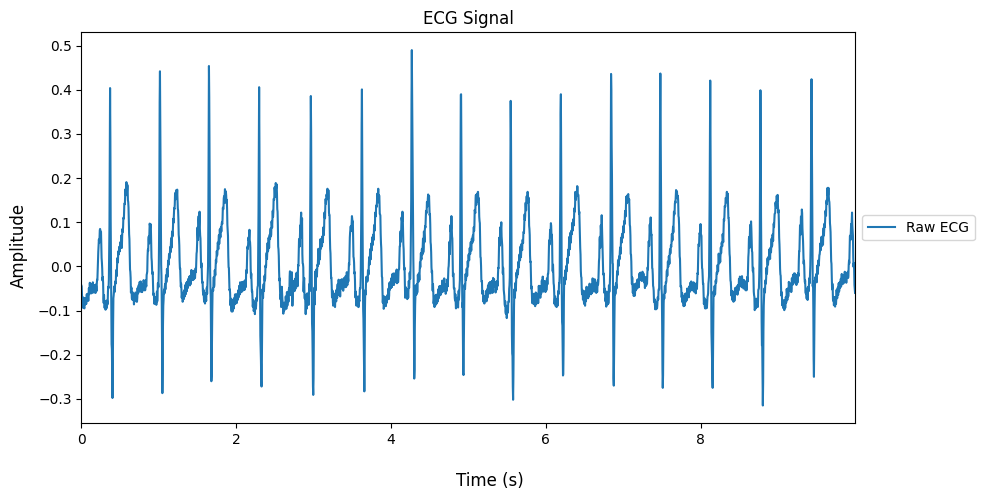

In [3]:
signals = {'Raw':sig}
biobss.ecgtools.plot_ecg(signals=signals, sampling_rate=fs, show_peaks=False, figsize=(10,5))

### __Create Pipeline Object__
<a id="create_pipeline"></a>

First, a pipeline object should be created.

In [4]:
pipeline = biobss.pipeline.Bio_Pipeline()   # Create a pipeline object

For windowed processing, __windowed_process__ should be set as __True__. Additionally, __window_size__ and __step_size __ should be defined. As an example, window_size=10 means that the pipeline will process 10 seconds of data at a time and step_size=5 means signal will be shifted by 5 seconds for each window (overlapped region).

In [5]:
pipeline_windowed = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=10,step_size=5)  # Create a pipeline object

### __Set Pipeline Inputs__
<a id="set_input"></a>

Pipeline input can be set using the __set_input__ method. 

In [6]:
# Set the input signal and sampling rate
pipeline.set_input(data=sig, sampling_rate=fs, name='ECG_Raw')
#pipeline_windowed.set_input(data=sig, sampling_rate=fs, name='PPG_Raw') 

### __Create Bio Process Objects__
<a id="create_bioprocess"></a>

Any process can be added to the pipeline by passing the method to a Bio_Process constructor. The Bio_Process constructor takes the following arguments:

- process_method: The method to be added to the pipeline
- process_name: Name of the method to be added to the pipeline
- **kwargs: Keyword arguments to be passed to the process method

Pipeline processes the given input sequentially. The input is passed from one process to the next.

For ECG signal, the processing given below is added to the pipeline:

 1. Filtering signals
    * Signal can be filtered with defining filters
      * <code> biobss.preprocess.filter_signal(sig,sampling_rate=fs,filter_type='bandpass',N=2,f_lower=0.5,f_upper=5) </code>
    * Siganls can be filtered with predefined filters
      * <code> biobss.preprocess.filter_signal(sig, sampling_rate=fs, signal_type='ECG', method='pantompkins') </code>
 2. Peak Detection

In [7]:
filter_ecg = biobss.pipeline.Bio_Process(process_method=biobss.preprocess.filter_signal,process_name="Filter ECG", signal_type='ECG', method='pantompkins')
find_peaks = biobss.pipeline.Bio_Process(process_method=biobss.ecgtools.ecg_detectpeaks,process_name='Find ECG Peaks',method="pantompkins")

In [8]:
ecg_delineate = biobss.pipeline.Bio_Process(process_method=neurokit2.ecg_delineate, process_name="Delineate ECG", delineator='neurokit2', method='peak')

In [9]:
pipeline.process_queue.add_process(filter_ecg , input_signals=['ECG_Raw'], output_signals=['ECG_Filtered'], sampling_rate = fs)
pipeline.process_queue.add_process(find_peaks , input_signals=['ECG_Filtered'], output_signals=['ECG_Peaks'], sampling_rate = fs,is_event=True)

In [10]:
pipeline.process_queue.add_process(ecg_delineate, input_signals={'ecg_cleaned':'ECG_Filtered', 'rpeaks':'ECG_Peaks'}, output_signals=['ECG_waves'], sampling_rate=fs, is_event=True)

In [11]:
pipeline.run_pipeline()

ValueError: Can only join Bio_Data objects

In [ ]:
pipeline.data

Since ECG signal has a complex waveform including P wave, QRS complex and T wave; BIOBSS also provides a delineation function. This function uses 'neurokit2' method from Neurokit2 package and returns a dictionary of all fiducial locations. The function requires R-peak locations to calculate the fiducial locations. If peaks_locs is not provided, the function calculates the locations itself using 'pantompkins' method.

In [ ]:
_, fiducials = neurokit2.ecg_delineate(ecg_cleaned=sig, rpeaks=locs_peaks, sampling_rate=fs, method='peak')

p_peaks_locs = fiducials['ECG_P_Peaks']
q_peaks_locs = fiducials['ECG_Q_Peaks']
s_peaks_locs = fiducials['ECG_S_Peaks']
t_peaks_locs = fiducials['ECG_T_Peaks']
p_onset_locs = fiducials['ECG_P_Onsets']
t_offset_locs = fiducials['ECG_T_Offsets']

### <font color='Green'>__Create Feature Objects__ </font>
<a id="create_feature"></a>

<font color='Red'>The cell below should be modified after resolving the discrete input issue. </font>

In [ ]:
# Create feature extraction steps

# Extract time domain features. input_signals dictionary contains feature prefixes as keys and input signals as values
# For example rms of EDA_Tonic is extracted as Tonic_rms in this case
Rpeak_features = biobss.pipeline.Feature(name="Rpeak_features", function=biobss.ecgtools.from_Rpeaks, sampling_rate=fs)


In [ ]:
# BIOBSS Pipeline is created
# windowed_process=True means that the pipeline will process the signal in windows
# window_size=60 means that the pipeline will process 60 seconds of data at a time
# step_size=20 means signal will be shifted by 20 seconds for each window
pipeline = biobss.pipeline.Bio_Pipeline(windowed_process=False)

In [ ]:
#pipeline = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=5,step_size=1)

In [ ]:
# Pipeline input can be set from an array, a dataframe, pandas series, list, Bio_Channel, Bio_Data

# In this case, the pipeline input is set with an array
#pipeline.set_input(sig,sampling_rate=fs,name='ECG_Raw')

# Alternatively, the pipeline input can be set with a Bio_Channel object, in this case the name and sampling rate are not required as they are already provided in the Bio_Channel object
pipeline.set_input(bio_channel)

pipeline.input

#### __Add Bio Process Objects to Pipeline__
<a id="add_bioprocess"></a>

In [ ]:
# Pipeline steps are added to the pipeline sequentially, the order of the steps is important as the output of one step is the input of the next step
# These steps will be processed in the order they are added to the pipeline
pipeline.process_queue.add_process(clean, input_signals="ECG_Raw", output_signals="ECG_Clean")
pipeline.process_queue.add_process(normalize, input_signals="ECG_Clean", output_signals="ECG_Normalized")
pipeline.process_queue.add_process(find_peaks,input_signals="ECG_Normalized",output_signals="ECG_Peaks")


# Currently all the steps are added to the preprocess_queue
# After the preprocess_queue is processed, data will be segmented into windows (if windowed_process=True)
# For running process in windows, the process_queue is used

## This structure will change in the future

#### __Add Feature Objects to Pipeline__
<a id="add_feature"></a>

In [ ]:
# Features are added to the pipeline
pipeline.add_feature_step(Rpeak_features, input_signals=['ECG_Raw', 'Events_ECG_Normalized'])


In [ ]:
# Represetation of the pipeline
pipeline

#### __Run Pipeline__
<a id="run_pipeline"></a>

In [ ]:
# Pipeline is run, this will process the input data in the pipeline
pipeline.run_pipeline()

In [ ]:
# Represetation of the pipeline data after running
pipeline.data

# Data is cleaned
# Data is normalized
# Data is decomposed into tonic and phasic components, these componenets are added to the pipeline data as EDA_Tonic and EDA_Phasic channels
# Lastly, data is resampled to 350Hz (All channels are resampled to 350Hz) (target_sample_rate=350)
# Data is segmented into windows of 60 seconds with a step size of 20 seconds

#### __Extract Features__
<a id="extract_features"></a>

In [ ]:
# Statistical and signal features are extracted from the EDA_Tonic, EDA_Phasic and EDA_Raw channels
# Supplied prefix is added to the feature name
pipeline.extract_features()



In [ ]:
# Represetation of the pipeline features after extraction
# Each row is a feature vector for a window
# index is the timestamp of the window (this can be selected as start, end or center of the window)
pipeline.features